In [75]:
import sys
import os
import xml.etree.ElementTree
import csv
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

% matplotlib inline

# Openstreetmap Project

The goal of this project is to parse data from a openstreetmap OSM file (XML format), populate a database and perform some analysis.

## List of modules used

In [2]:
print("Python: Version %s"%(sys.version))
print("xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.")
print("csv: Version %s"%(csv.__version__))
print("re: Version %s"%(re.__version__))
#print("sqlite3: Version %s"%(sqlite3.__version__))
print("pandas: Version %s"%(pd.__version__))


Python: Version 3.6.0 |Anaconda 4.3.1 (32-bit)| (default, Dec 23 2016, 12:06:52) [MSC v.1900 32 bit (Intel)]
xml.etree.ElementTree: xml is a python embedded module. Please refer to the python's version.
csv: Version 1.0
re: Version 2.2.1
pandas: Version 0.19.2


## Set the data file

In [3]:
#dataFileName = 'example.osm'
dataFileName = 'daensen.osm'

In [4]:
statinfo = os.stat(dataFileName)
print('Size of the source file {}: {:.3f}Mb'.format(dataFileName, statinfo.st_size / (1024 * 1024))) 

Size of the source file daensen.osm: 0.244Mb


# Read data from OSM file and create some csv files

In [5]:
# List of all csv files
csvFiles = {'node':'nodes.csv',
         'way':'ways.csv',
         'node_tags': 'nodes_tags.csv',
         'way_tags': 'ways_tags.csv',
         'way_node':'ways_nodes.csv'}

# List of all fields for the csv files
fields = {'node': ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'way': ['id', 'user', 'uid', 'version', 'changeset', 'timestamp'],
           'node_tags': ['id', 'key', 'value', 'type'],
           'way_tags': ['id', 'key', 'value', 'type'],
           'way_node': ['id', 'node_id', 'position']} 

def initCSVfiles():
    '''
    Create empty csv files and add the header line
    
    parameters:
    ------------
    None
    
    returns:
    --------
    a dictionary containing the file descriptor and the csv writer object
    '''
    fileDescriptor = {}
    for f in csvFiles:
        #print('init {}'.format(files[f]))
        fileId = open(csvFiles[f], 'w', encoding='utf-8')
        csvWriter = csv.writer(fileId, delimiter=';',
                            quotechar='\'', quoting=csv.QUOTE_MINIMAL)
        csvWriter.writerow(fields[f])
        fileDescriptor[f] = {}
        fileDescriptor[f]['fileId'] = fileId
        fileDescriptor[f]['csvWriter'] = csvWriter
        
    return fileDescriptor

def closeCSVfiles(fileDesc):
    '''
    Close all csv files opened
    
    parameters:
    -----------
    the file descriptor dictionary returned by the initCSVfiles function.
    
    returns:
    --------
    None
    '''
    for f in fileDesc:
        fileDesc[f]['fileId'].close()

def writeElem(elemType, elem, fileDesc):
    '''
    write an element in the corresponding csv file
    
    parameters:
    -----------
    - elemType: a string of the type of element to be written.
    - elem: dict of data to be written in the csv file
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)
    '''
    record = []
    for i in fields[elemType]:
        record.append(elem[i])
    
    fileDesc[elemType]['csvWriter'].writerow(record)

def parseTag(id, attrib):
    '''
    Parse the tag k and return the value, the key and the type
    
    parameters:
    -----------
    - id: id of the node or the way
    - attrib: XML object
    
    returns:
    --------
    a dictionary with the Id of the parent, the key, value and type
    '''
    
    if 'k' in attrib:
        pattern = re.compile('^([a-z_]+):(.*)$')
        match = pattern.match(attrib['k'])
    
        if match:
            type_ = match.group(1)
            key = match.group(2)
        else:
            type_ = attrib['k']
            key = ''
    else:
        key = None
        type_ = None
    
    # Replace semi-colon by a space in the value string to avoid issues by reading the csv file.
    value = attrib['v'].replace(';', ' ')
    return {'id': id, 'key':key, 'value':value, 'type':type_}
    
def parseElement(element, fileDesc):
    '''
    parse an element and write the data in the different csv files
    
    parameters:
    -----------
    - element: XML object to be parsed
    - fileDesc: dictionary of the file decriptor (given by the initCSVfiles function)

    returns:
    --------
    None
    '''
    targetElement = ['node', 'way']
    
    if element.tag in targetElement:
        #print('Parsing: {}'.format(element.tag))
        selectedAttribs = fields[element.tag]

        # Parse the main elements Node and Way
        attribs = element.attrib
        elem = {}
        for i in selectedAttribs:
            elem[i] = attribs[i]  
        writeElem(element.tag, elem, fileDesc)
        
        # Parse the subelements Tag and Nd
        position = 0
        for e in element:
            tag = {}
            node = {}
            if e.tag == 'nd':
                node = {'id': elem['id'], 'node_id': e.attrib['ref'], 'position': position}
                position += 1
                writeElem('way_node', node, fileDesc)
            elif e.tag == 'tag':
                tag = parseTag(elem['id'], e.attrib)
                writeElem(element.tag + '_tags', tag, fileDesc)
        
def parseOSMfile(fileName):
    '''
    main function to extract the data from an OSM file to CSV files
    
    parameters:
    -----------
    fileName: string of the path of the OSM file
    
    returns:
    --------
    None
    '''
    fileDesc = initCSVfiles()
    e = xml.etree.ElementTree.parse(fileName).getroot()
    for element in e:
        parseElement(element, fileDesc)
    closeCSVfiles(fileDesc)

Now we can generate the CSV files:

In [6]:
parseOSMfile(dataFileName)

We see all CSV files in the current directory:

In [7]:
fileList = os.listdir()

print('List of csv files.')
pattern = re.compile('.*\.csv$')
for f in fileList:
    if pattern.match(f):
        statinfo = os.stat(f)
        print('File {} ({:.1f}kb)'.format(f, statinfo.st_size / 1024))
    

List of csv files.
File nodes.csv (55.5kb)
File nodes_tags.csv (3.9kb)
File node_tags.csv (3.9kb)
File ways.csv (7.2kb)
File ways_nodes.csv (19.5kb)
File ways_tags.csv (8.2kb)
File way_node.csv (19.5kb)
File way_tags.csv (8.2kb)


Those files can be used to populate the database

# Create the database

It is necessary to create the database only once. A variable can be use to avoid to create the tables everytime the notebook is executed.

In [8]:
# Set this variable to True to for the regeneration of the database
regenerateDatabase = True

Create the database with the schema contains in the file 'data_wrangling_schema.sql'

In [20]:
conn = sqlite3.connect('Openstreetmap.db')
c = conn.cursor()

In [9]:
with open('data_wrangling_schema.sql') as f: 
    text = f.read()
    c.executescript(text)
    conn.commit()
    print('Execute SQL statement: \n{}'.format(text))


Execute SQL statement: 
CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);

CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);

CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
);



# Populate the database

In [10]:
def populateDatabase(dbConn):
    for f in csvFiles:
        print('Reading file {} for table {}'.format(csvFiles[f], csvFiles[f].split('.')[0]))
        df = pd.read_csv(csvFiles[f], sep=';')
        df.to_sql(csvFiles[f].split('.')[0], dbConn, if_exists='replace', index=False)

In [11]:
populateDatabase(conn)

Reading file nodes.csv for table nodes
Reading file ways.csv for table ways
Reading file nodes_tags.csv for table nodes_tags
Reading file ways_tags.csv for table ways_tags
Reading file ways_nodes.csv for table ways_nodes


Now the database is populated and can be use.

# Analyse the data

## How many nodes in th database?

In [21]:
c.execute('SELECT COUNT(id) FROM nodes')
print('There are {} nodes in the database'.format(c.fetchall()[0][0]))

There are 675 nodes in the database


## How many ways in the database?

In [22]:
c.execute('SELECT COUNT(id) FROM ways')
print('There are {} ways in the database'.format(c.fetchall()[0][0]))

There are 118 ways in the database


## How many users are in the tables?

In [23]:
c.execute('SELECT COUNT(DISTINCT user) FROM ways')
print('There are {} different users in the ways table'.format(c.fetchall()[0][0]))

c.execute('SELECT COUNT(DISTINCT user) FROM nodes')
print('There are {} different users in the nodes table'.format(c.fetchall()[0][0]))

There are 7 different users in the ways table
There are 15 different users in the nodes table


## What about fire protection?

In [56]:
c.execute('SELECT count(type) \
          FROM nodes_tags \
          WHERE type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
print('There are {} fire hydrant in the database'.format(c.fetchall()[0][0]))

There are 13 fire hydrant in the database


We can extract their position.

In [60]:
c.execute('SELECT nodes.lat, nodes.lon, nodes_tags.type, nodes_tags.key, nodes_tags.value \
          FROM nodes \
          JOIN nodes_tags ON nodes.id = nodes_tags.id \
          WHERE nodes_tags.type == \'fire_hydrant\' AND nodes_tags.key = \'type\';')
res = c.fetchall()
res

[(53.41958149999999, 9.6971642, 'fire_hydrant', 'type', 'underground'),
 (53.4199681, 9.6968844, 'fire_hydrant', 'type', 'underground'),
 (53.420046400000004, 9.693318, 'fire_hydrant', 'type', 'underground'),
 (53.4201353, 9.695699900000001, 'fire_hydrant', 'type', 'underground'),
 (53.4213255, 9.69435, 'fire_hydrant', 'type', 'underground'),
 (53.421583, 9.694297500000001, 'fire_hydrant', 'type', 'pond'),
 (53.421855799999996, 9.6957095, 'fire_hydrant', 'type', 'underground'),
 (53.4221119, 9.6929105, 'fire_hydrant', 'type', 'underground'),
 (53.4221616, 9.6915516, 'fire_hydrant', 'type', 'underground'),
 (53.4224003, 9.6969722, 'fire_hydrant', 'type', 'underground'),
 (53.42303879999999, 9.6933044, 'fire_hydrant', 'type', 'underground'),
 (53.423207999999995, 9.6950783, 'fire_hydrant', 'type', 'underground'),
 (53.423454799999995, 9.6965059, 'fire_hydrant', 'type', 'underground')]

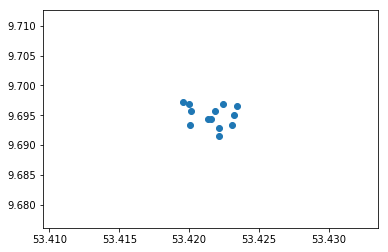

In [79]:
lat = []
lon = []
for i in res:
    lat.append(i[0])
    lon.append(i[1])
    
plt.scatter(lat, lon)
plt.show()

## Check of the name of the objects

In [33]:
c.execute('SELECT DISTINCT value FROM ways_tags WHERE type == \'name\'')
c.fetchall()

[('Golf Club Buxtehude',),
 ('Daensener Weg',),
 ('Daenser Weg',),
 ('Zum Baaksberg',),
 ('Zum Lehmfeld',),
 ('Koppelstieg',),
 ('Moisburger Landstraße',)]

# Close the database

In [16]:
conn.close()